# Large Language Model Loss Function Benchmark Analysis

This notebook analyzes and visualizes the performance of different loss functions:
- Standard Cross Entropy (CE)
- CE with NTL-MSE
- CE with NTL-Wasserstein
- CE with NTL-Absolute Difference

We'll examine:
1. Overall execution times
2. Detailed timing breakdowns
3. Impact of numerical content proportion
4. Statistical analysis of results

In [1]:
import os
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

# Set visualization defaults
sns.set_context("paper")
sns.set_palette("colorblind")

In [2]:
def get_all_file_paths(directory: str, contains: str = None) -> List[str]:
    """Get all file paths in directory that optionally contain a specific string."""
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if contains is None or contains in file:
                file_paths.append(os.path.join(root, file))
    return file_paths

def get_timestamp(string: str) -> str:
    """Extract timestamp from filename."""
    return string.split('_')[-1].split('.')[0]

In [24]:
def reshape_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and reshape benchmark data."""
    # Standardize loss function names
    loss_mapping = {
        'CE': 'CE Loss',
        'CE+MSE': 'CE Loss + NTL-MSE',
        'CE+Wasserstein': 'CE Loss + NTL-WAS-CDF',
        'CE+AbsDiff': 'CE Loss + NTL-WAS'
    }
    df['loss'] = df['loss'].replace(loss_mapping)
    df.rename(columns={'loss': 'Loss'}, inplace=True)

    # Standardize benchmark names
    benchmark_mapping = {
        'standalone': 'Standalone',
        'forward_pass': 'Forward pass',
        'training_step': 'Training step'
    }
    df['benchmark'] = df['benchmark'].replace(benchmark_mapping)

    # Compute complete pass metrics
    df['complete_pass'] = df['complete_pass'].fillna(
        df['preprocessing'] + 
        df['backward_pass'] + 
        df['forward_pass'] + 
        df['optimizer_step'].fillna(0)
    )
    
    df['complete_pass_err'] = df['complete_pass_err'].fillna(
        np.sqrt(
            df['preprocessing_err']**2 + 
            df['backward_pass_err']**2 + 
            df['forward_pass_err']**2 + 
            df['optimizer_step_err'].fillna(0)**2
        )
    )

    df.rename(columns={
        'complete_pass': 'mean_time',
        'complete_pass_err': 'error'
    }, inplace=True)

    return df

In [25]:
def get_df_by_number_share(directory: str) -> Dict[float, pd.DataFrame]:
    """Load and process benchmark data files grouped by number share."""
    file_paths = get_all_file_paths(directory, contains='.csv')
    dfs = {}

    for file_path in file_paths:
        timestamp = get_timestamp(file_path)
        config_file = get_all_file_paths(directory, contains=f'{timestamp}.stored_yaml')[0]
        
        with open(config_file, 'r') as file:
            config = yaml.safe_load(file)
            
        number_share = config['forward pass benchmark']['number_share']
        dfs[number_share] = reshape_data(pd.read_csv(file_path))

    return dict(sorted(dfs.items()))

In [120]:
# Load benchmark data
dfs = get_df_by_number_share('gpu/benchmarking/newest')

In [121]:
# Show example data
dfs[0.1].head()

,benchmark,Loss,backward_pass,backward_pass_err,mean_time,error,data_generation,data_generation_err,forward_pass,forward_pass_err,optimizer_step,optimizer_step_err,preprocessing,preprocessing_err
0,Standalone,CE Loss,NaN,NaN,0.008958,0.000512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Standalone,CE Loss + NTL-MSE,NaN,NaN,0.009178,0.000021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Standalone,CE Loss + NTL-WAS-CDF,NaN,NaN,0.025680,0.000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Standalone,CE Loss + NTL-WAS,NaN,NaN,0.009031,0.000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Forward pass,CE Loss,0.085509,0.00564,0.134016,0.006620,0.645678,0.013435,0.040107,0.003445,NaN,NaN,0.0084,0.000386


In [141]:
def combined_paper_plots(df, save = False):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = sorted(df["Loss"].unique())  # Sort loss functions for a consistent legend order
    
    # Define a colorblind-friendly palette
    palette = sns.color_palette("colorblind")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}
    
    # Arrange subplots in a single column
    n_rows = len(benchmarks)
    fig, axes = plt.subplots(n_rows, 1, figsize=(6, 1.8 * n_rows), sharex=False)

    # Ensure axes is a list even for a single benchmark
    if n_rows == 1:
        axes = [axes]
    
    # Plot for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark]
        x_positions = np.arange(len(subset))
        
        # Plot horizontal bars with error bars
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            ax.barh(x_positions[j], 
                    mean_time * 1_000,  # Scale mean_time to ms
                    xerr=error * 1_000,  # Scale error to ms
                    capsize=3,  # Smaller cap size for a cleaner look
                    color=color_map[loss], 
                    alpha=0.85)

        # Customize each subplot
        ax.set_yticks(x_positions)
        ax.set_yticklabels(subset["Loss"], fontsize=10, weight="bold")  # Bold for better readability
        ax.set_title(benchmark, fontsize=12, weight="bold", loc="center")  # Center-align titles
        ax.grid(axis="x", linestyle="--", alpha=0.6)  # Add gridlines for x-axis only
        if i == n_rows - 1:
            ax.set_xlabel("Time (ms)", fontsize=12, weight="bold")

        # Dynamic x-axis scaling for each subplot
        max_runtime = (subset["mean_time"] + subset["error"]).max() * 1_000
        ax.set_xlim(0, max_runtime * 1.2)  # Add a 20% buffer above the widest bar

    # Adjust layout to minimize whitespace and align subplots
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the legend below
    if(save):
        plt.savefig("benchmarking_plots.png", dpi=300, bbox_inches="tight")
    plt.show()

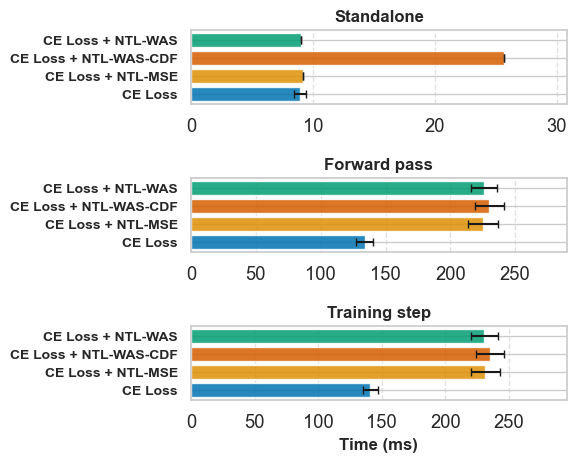

In [142]:
combined_paper_plots(dfs[0.1], save = True)

In [124]:
def combined_plots(df, save = False):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()

    # Define colors using Seaborn palette
    palette = sns.color_palette("colorblind")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}

    # Set up the plot with one subplot per benchmark
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=True)

    # Calculate the overall tallest bar for consistent buffer across all subplots
    max_runtime = (df["mean_time"] + df["error"]).max() * 1_000

    # Plot for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions
        x_positions = np.arange(len(subset))
        
        # Plot bars with error bars, using different colors for each loss function
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            ax.bar(x_positions[j], mean_time * 1_000,  # Scale mean_time to ms
                   yerr=error * 1_000,  # Scale error to ms
                   capsize=5, color=color_map[loss], alpha=0.8, label=loss if i == 0 else "")

        # Customize each subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
        ax.set_title(benchmark, fontsize=16, weight="bold")
        if i == 0:
            ax.set_ylabel("Time (ms)", fontsize=14)
        
        # Add buffer zone above tallest bar
        ax.set_ylim(0, max_runtime * 1.2)  # Add 20% buffer above the tallest bar

    # Add a single legend outside the plot
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
    fig.legend(handles, loss_functions, title="Loss Function", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
    if(save):
        plt.savefig("combined_plots.png", dpi=300, bbox_inches="tight")
    # Show the plot
    plt.show()

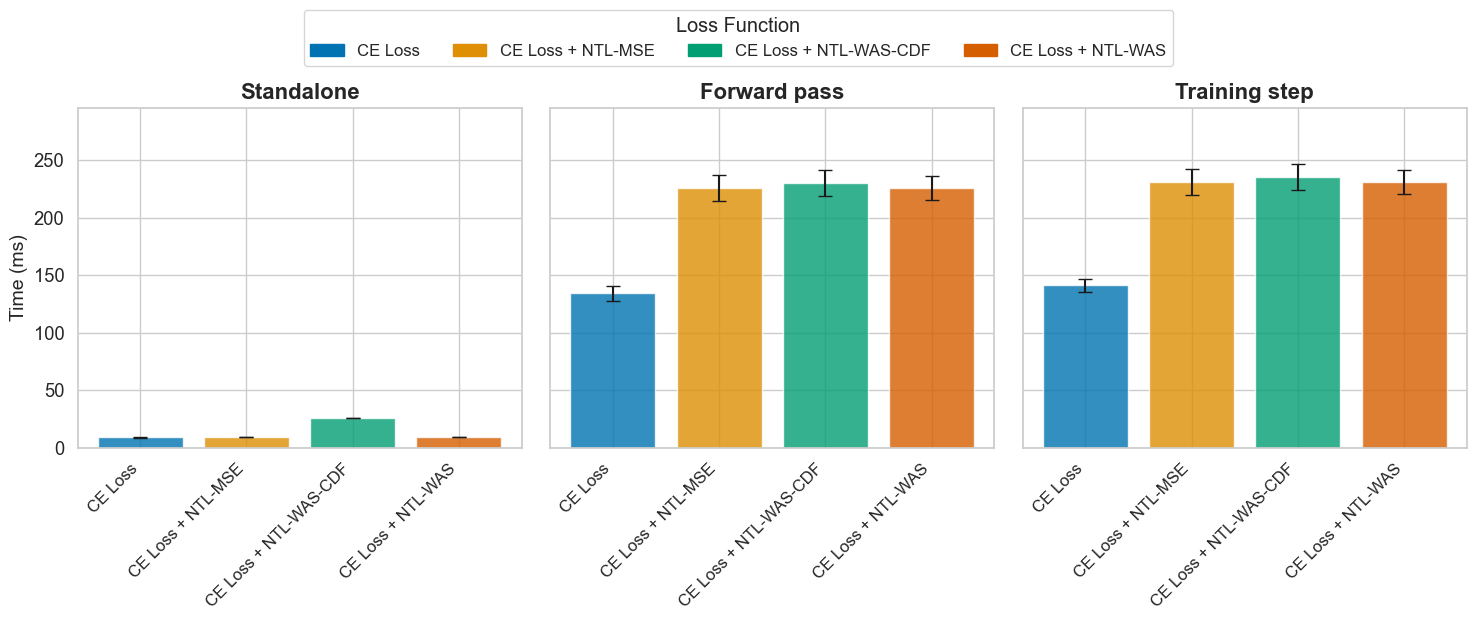

In [125]:
combined_plots(dfs[0.1])

In [126]:
def combined_plots_y_scaled(df, save = False):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()
    
    # Define colors using Seaborn palette
    palette = sns.color_palette("colorblind")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}
    
    # Set up the plot with one subplot per benchmark
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=False)
    
    # Plot for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark]
        x_positions = np.arange(len(subset))
        
        # Plot bars with error bars, using different colors for each loss function
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], 
                                                        subset["mean_time"], 
                                                        subset["error"])):
            ax.bar(x_positions[j], 
                  mean_time * 1_000,  # Scale mean_time to ms
                  yerr=error * 1_000,  # Scale error to ms
                  capsize=5, 
                  color=color_map[loss], 
                  alpha=0.8, 
                  label=loss if i == 0 else "")
        
        # Customize each subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
        ax.set_title(benchmark, fontsize=16, weight="bold")
        ax.set_ylabel("Time (ms)", fontsize=14)
        
        # Dynamic y-axis scaling for each subplot
        max_runtime = (subset["mean_time"] + subset["error"]).max() * 1_000
        ax.set_ylim(0, max_runtime * 1.2)  # Add 20% buffer above the tallest bar
    
    # Add a single legend outside the plot
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
    fig.legend(handles, 
              loss_functions, 
              title="Loss Function", 
              loc="upper center", 
              bbox_to_anchor=(0.5, 1.05), 
              ncol=4, 
              fontsize=12)
    
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
    if(save):
        plt.savefig("combined_benchmark_plots_y_scaled.png", dpi=300, bbox_inches="tight")
    plt.show()

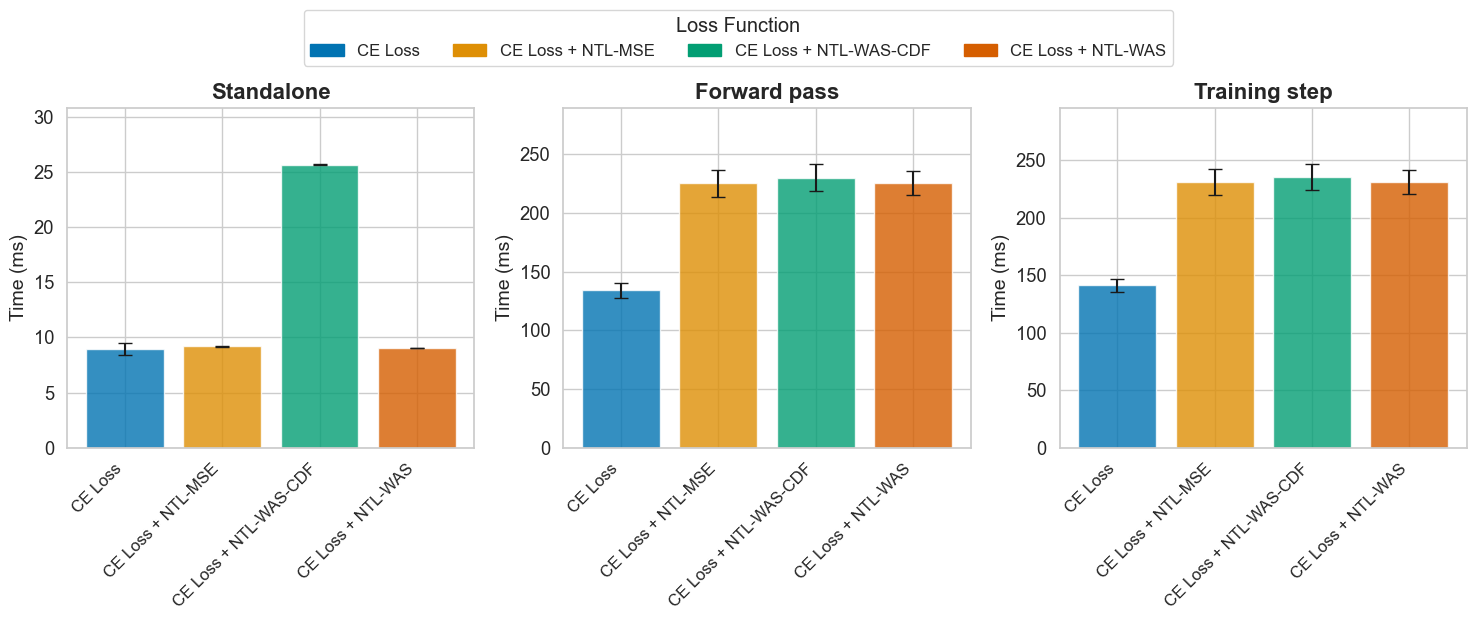

In [127]:
combined_plots_y_scaled(dfs[0.1])

In [114]:
def plot_relative_speedup(df, save = False):
   # Set Seaborn style for publication-ready visuals
   sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
   
   # Unique benchmarks and loss functions
   benchmarks = df["benchmark"].unique()
   loss_functions = df["Loss"].unique()
   
   # Define colors using Seaborn palette 
   palette = sns.color_palette("colorblind")
   color_map = {loss: color for loss, color in zip(loss_functions, palette)}
   
   # Set up the plot with one subplot per benchmark
   fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=False)
   
   # Calculate relative speedup for each benchmark
   for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
       subset = df[df["benchmark"] == benchmark].copy()  # Use .copy() to avoid SettingWithCopyWarning
       
       # Extract runtime and error for "CE Loss"
       ce_loss = subset[subset["Loss"] == "CE Loss"]
       if len(ce_loss) > 1:
           # If there are multiple entries, aggregate them
           ce_loss_time = ce_loss["mean_time"].mean()
           ce_loss_error = ce_loss["error"].mean()
       else:
           # Otherwise, use the single entry
           ce_loss_time = ce_loss["mean_time"].values[0]
           ce_loss_error = ce_loss["error"].values[0]
           
       # Calculate relative speedup: divide all loss times by CE Loss time
       subset.loc[:, "relative_speedup"] = subset["mean_time"] / ce_loss_time
       
       # Properly propagate error: includes contributions from both subset error and CE Loss error
       subset.loc[:, "relative_error"] = subset["relative_speedup"] * np.sqrt(
           (subset["error"] / subset["mean_time"])**2 + 
           (ce_loss_error / ce_loss_time)**2
       )
       
       # Bar positions
       x_positions = np.arange(len(subset))
       
       # Plot bars with relative speedup and error bars
       for j, (loss, speedup, error) in enumerate(zip(subset["Loss"], 
                                                     subset["relative_speedup"], 
                                                     subset["relative_error"])):
           ax.bar(x_positions[j], 
                 speedup,
                 yerr=error, 
                 capsize=5,
                 color=color_map[loss], 
                 alpha=0.8, 
                 label=loss if i == 0 else "")
       
       # Customize each subplot
       ax.set_xticks(x_positions)
       ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
       ax.set_title(benchmark, fontsize=16, weight="bold")
       ax.set_ylabel("Relative Speedup", fontsize=14)
       ax.set_ylim(0, subset["relative_speedup"].max() * 1.2)  # Dynamic y-axis scaling
       
       # Add horizontal line at speedup = 1 for reference
       ax.axhline(1, color="gray", linestyle="--", linewidth=1)
   
   # Add a single legend outside the plot
   handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
   fig.legend(handles, 
             loss_functions, 
             title="Loss Function", 
             loc="upper center", 
             bbox_to_anchor=(0.5, 1.05), 
             ncol=4, 
             fontsize=12)
   
   # Adjust layout and save the figure
   plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
   if(save):
      plt.savefig("relative_speedup_plots.png", dpi=300, bbox_inches="tight")
   plt.show()

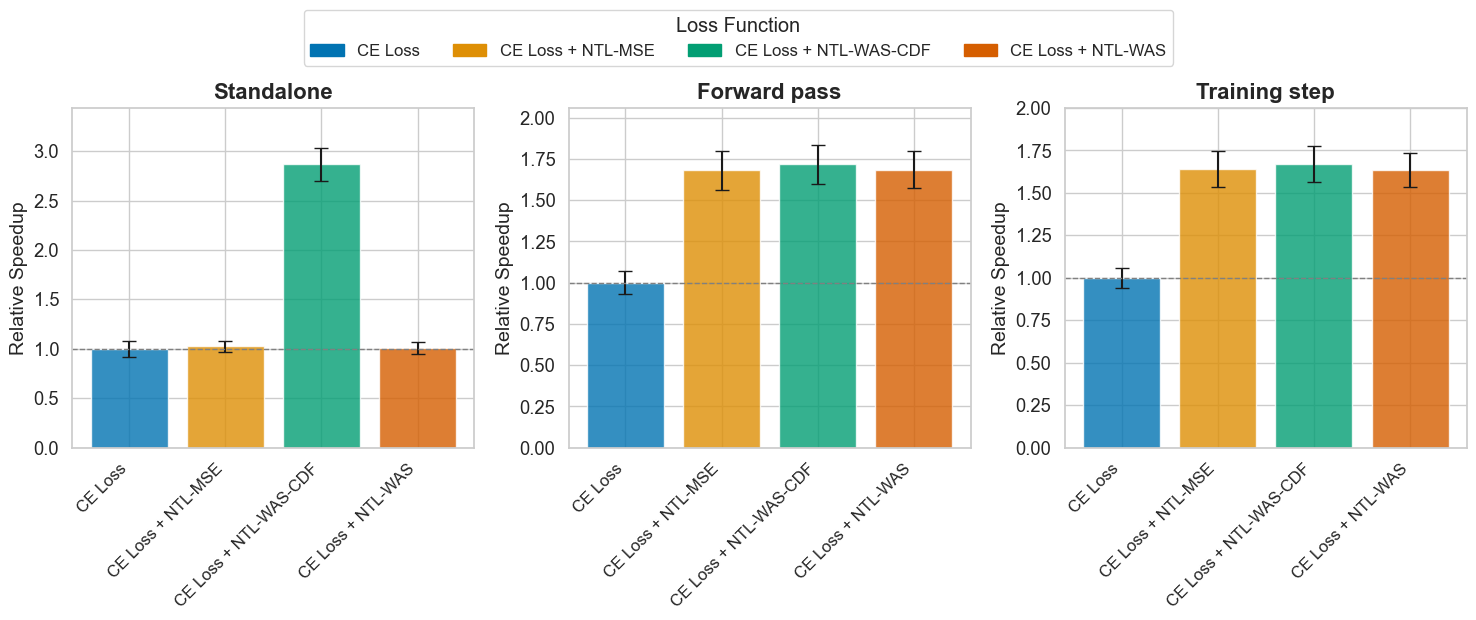

In [115]:
plot_relative_speedup(dfs[0.1])

In [116]:
def plot_number_share(data, save = False):
   # Set Seaborn style
   sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
   
   # Extract unique benchmarks and losses
   benchmarks = data[0.1]["benchmark"].unique()
   loss_functions = data[0.1]["Loss"].unique()
   
   # Define colors for losses
   palette = sns.color_palette("colorblind")
   loss_colors = {loss: palette[i] for i, loss in enumerate(loss_functions)}
   
   # Plot each benchmark
   for benchmark in benchmarks:
       plt.figure(figsize=(10, 8))
       x_positions = np.arange(len(data))
       bar_width = 0.2
       max_runtime = 0
       
       # Plot bars for each loss function
       for i, loss in enumerate(loss_functions):
           mean_times = []
           std_devs = []
           
           for portion, df in data.items():
               subset = df[(df['benchmark'] == benchmark) & (df['Loss'] == loss)]
               mean_time_ms = subset['mean_time'].values[0] * 1_000  # Scale to ms
               error_ms = subset['error'].values[0] * 1_000  # Scale error to ms
               
               mean_times.append(mean_time_ms)
               std_devs.append(error_ms)
               max_runtime = max(max_runtime, mean_time_ms + error_ms)
           
           plt.bar(x_positions + i * bar_width, 
                  mean_times,
                  yerr=std_devs,
                  capsize=4,
                  width=bar_width, 
                  color=loss_colors[loss], 
                  label=loss, 
                  alpha=0.9)
       
       # Configure plot
       plt.ylim(0, max_runtime * 1.4)
       plt.title(f"Runtime for Benchmark: {benchmark}", fontsize=18, weight='bold')
       plt.xlabel("Number Share", fontsize=14)
       plt.ylabel("Mean Runtime (ms)", fontsize=14)
       plt.xticks(ticks=x_positions + bar_width * (len(loss_functions)-1) / 2,
                 labels=[str(k) for k in data.keys()], 
                 fontsize=12)
       plt.yticks(fontsize=12)
       
       # Add legend
       handles = [plt.Rectangle((0, 0), 1, 1, color=loss_colors[loss]) for loss in loss_functions]
       plt.legend(handles, 
                 loss_functions, 
                 title="Loss Function", 
                 fontsize=12, 
                 loc="upper left")
       
       # Finalize and save
       plt.grid(axis='y', linestyle='--', alpha=0.7)
       plt.tight_layout(rect=[0, 0, 1, 0.9])
       if(save):
        plt.savefig(f"runtime_benchmark_{benchmark.replace(' ', '_')}.png", 
                    dpi=300, 
                    bbox_inches="tight")
       plt.show()

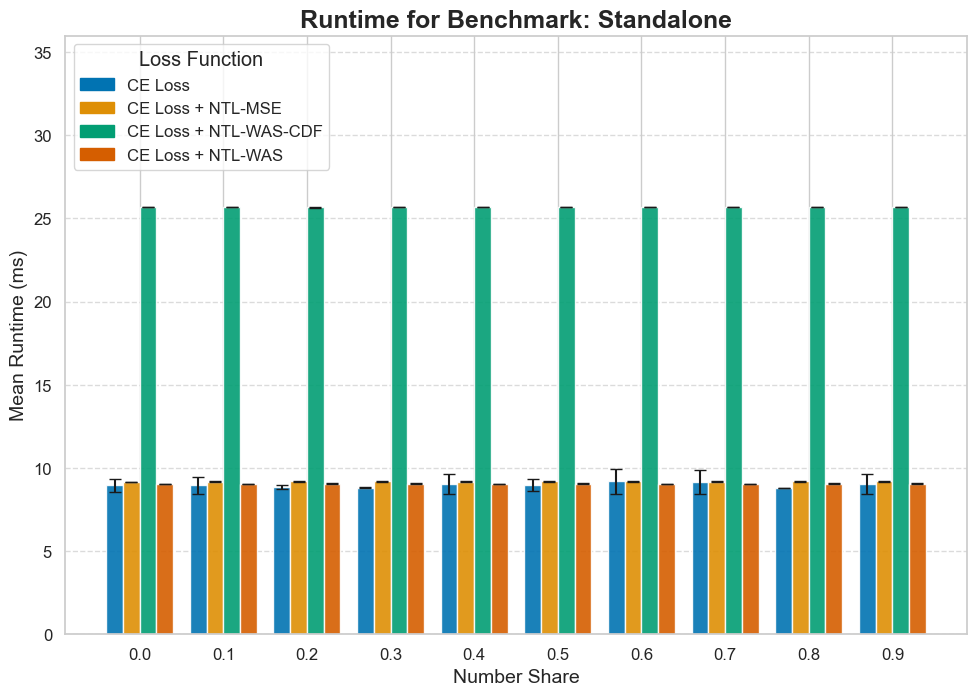

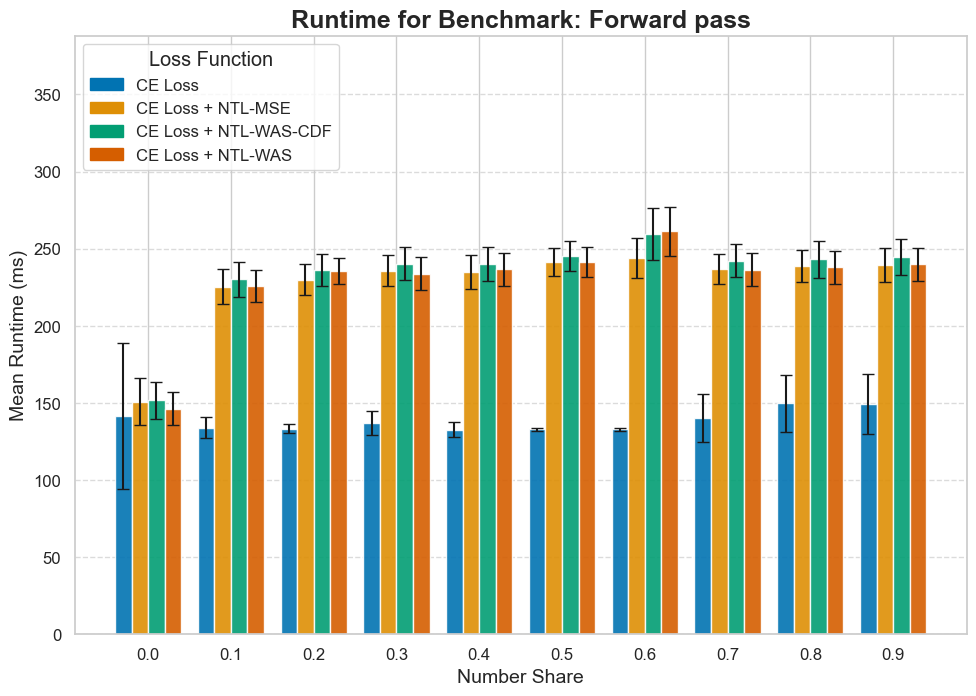

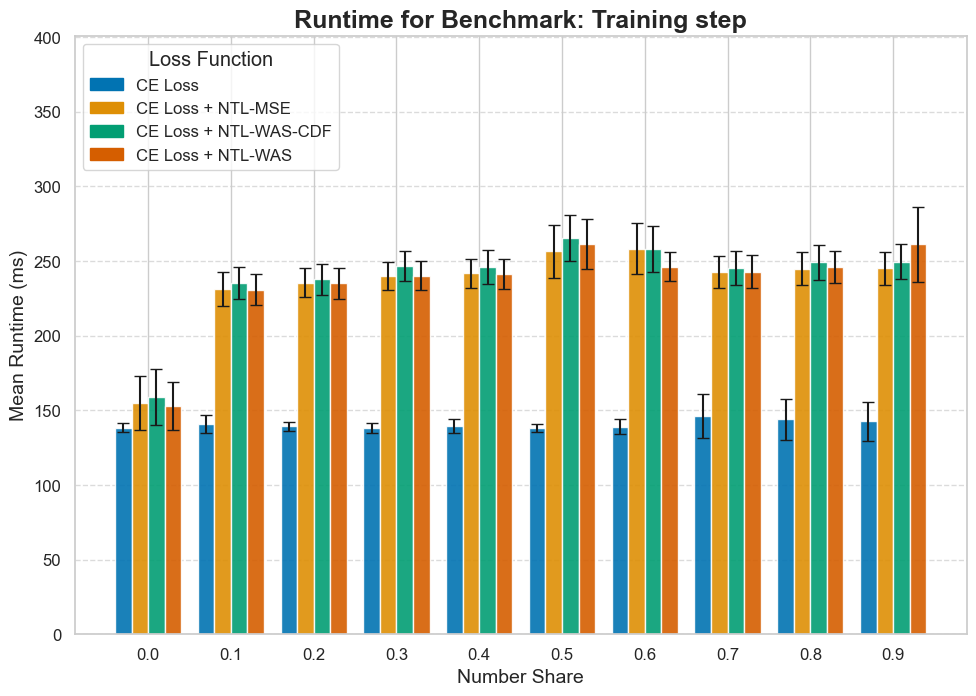

In [117]:
plot_number_share(dfs)

In [118]:
def plot_segment_influence(benchmark_dict, save = False):
   sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
   
   segments = ["data_generation", "preprocessing", "forward_pass", 
               "backward_pass", "optimizer_step"]
   segment_errs = [f"{seg}_err" for seg in segments]
   
   # Combine DataFrames
   combined_df = []
   for number_share, df in benchmark_dict.items():
       df["number_share"] = number_share
       combined_df.append(df)
   combined_df = pd.concat(combined_df, ignore_index=True)
   
   # Create subplots
   fig, axes = plt.subplots(1, len(segments), figsize=(5 * len(segments), 6), sharey=False)
   
   # Plot segments
   for i, (segment, segment_err, ax) in enumerate(zip(segments, segment_errs, axes)):
       max_value = 0
       for loss in combined_df["Loss"].unique():
           subset = combined_df[combined_df["Loss"] == loss]
           max_value = max(max_value, 
                         (subset[segment] * 1000).max() + 
                         (subset[segment_err] * 1000).max())
           
           ax.errorbar(subset["number_share"],
                      subset[segment] * 1000,
                      yerr=subset[segment_err] * 1000,
                      label=loss,
                      marker="o",
                      capsize=5)
                      
       # Customize subplot
       ax.set_title(segment.replace("_", " ").capitalize(), 
                   fontsize=16, weight="bold")
       ax.set_xlabel("Number Share", fontsize=14)
       ax.set_ylabel("Time (ms)", fontsize=14)
       ax.set_ylim(0, max_value * 1.1)
   
   # Add legend
   handles, labels = ax.get_legend_handles_labels()
   fig.legend(handles, labels, 
             title="Loss Function", 
             loc="upper center",
             bbox_to_anchor=(0.5, 1.05), 
             ncol=4, 
             fontsize=12)
             
   plt.tight_layout(rect=[0, 0, 1, 0.95])
   if(save):
    plt.savefig("segment_influence_by_number_share.png", dpi=300, bbox_inches="tight")
   plt.show()

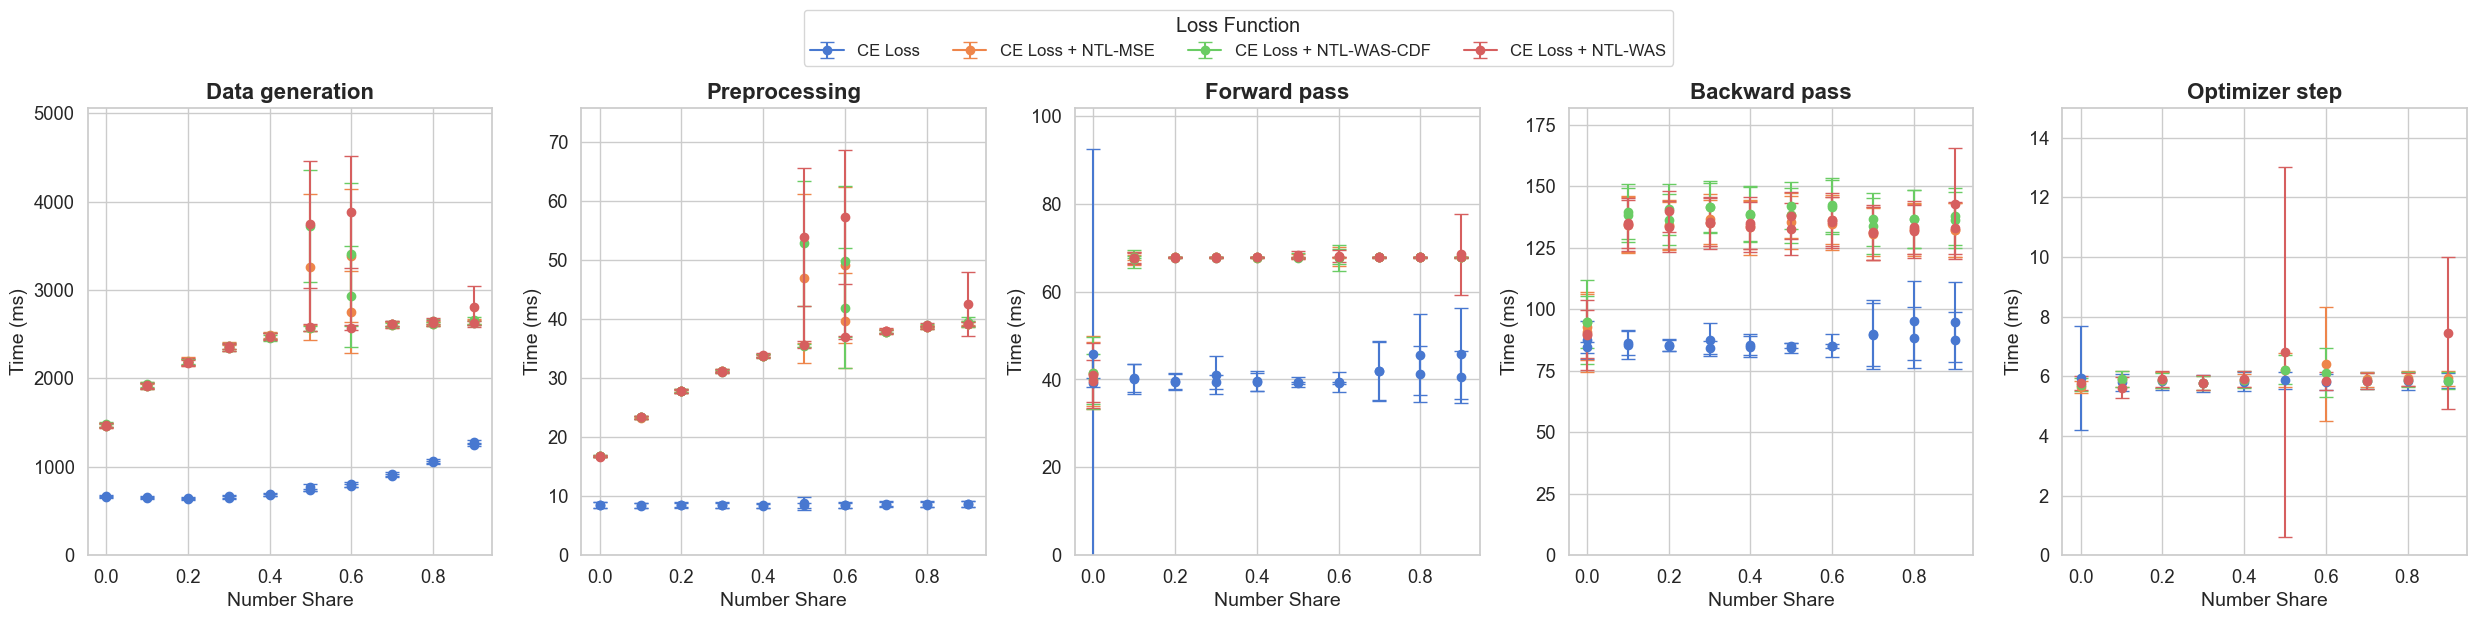

In [119]:
plot_segment_influence(dfs)